![Kayak](https://seekvectorlogo.com/wp-content/uploads/2018/01/kayak-vector-logo.png)
# Planifie ton voyage avec Kayak
## Description de l’entreprise 📇

<a href="https://www.kayak.com" target="_blank">Kayak</a> est un moteur de recherche de voyages qui aide les utilisateurs à planifier leurs déplacements au meilleur prix.

L’entreprise a été fondée en 2004 par Steve Hafner et Paul M. English.
Après plusieurs levées de fonds, Kayak a été rachetée par <a href="https://www.bookingholdings.com/" target="_blank">Booking Holdings</a>, qui possède aujourd’hui :

* <a href="https://booking.com/" target="_blank">Booking.com</a>
* <a href="https://kayak.com/" target="_blank">Kayak</a>
* <a href="https://www.priceline.com/" target="_blank">Priceline</a>
* <a href="https://www.agoda.com/" target="_blank">Agoda</a>
* <a href="https://Rentalcars.com/" target="_blank">RentalCars</a>
* <a href="https://www.opentable.com/" target="_blank">OpenTable</a>

Avec plus de $300 millions de dollars de chiffre d’affaires annuel, Kayak opère dans la quasi-totalité des pays et des langues, afin d’aider ses utilisateurs à réserver leurs voyages partout dans le monde.


## Projet 🚧

L’équipe marketing a besoin d’aide pour un nouveau projet.
Après avoir mené une étude utilisateur, elle a découvert que **70 % des utilisateurs qui préparent un voyage souhaiteraient disposer de plus d’informations sur leur destination**.

De plus, cette étude montre que **les utilisateurs ont tendance à se méfier des informations qu’ils lisent lorsqu’ils ne connaissent pas la marque** qui en est à l’origine.

Ainsi, l’équipe marketing de Kayak souhaite créer une application capable de recommander les destinations de vacances idéales.
Cette application devra s’appuyer sur des données réelles concernant :

* la météo,
* les hôtels disponibles dans la région.

L’application devra ensuite être en mesure de recommander les meilleures destinations et hôtels en fonction de ces variables, à tout moment.


## Objectifs 🎯

Le projet venant tout juste de débuter, votre équipe ne dispose d’aucune donnée exploitable pour créer l’application.
Votre mission sera donc de :

* Extraire (scraper) des données sur différentes destinations
* Récupérer les données météorologiques de chaque destination
* Collecter les informations sur les hôtels de chaque destination
* Stocker l’ensemble de ces informations dans un data lake
* Extraire, transformer et charger (ETL) les données nettoyées depuis le data lake vers un data warehouse


## Périmètre du projet 🖼️

L’équipe marketing souhaite d’abord se concentrer sur les meilleures villes à visiter en France.
Selon <a href="https://one-week-in.com/35-cities-to-visit-in-france/" target="_blank">One Week In.com</a>, voici les 35 principales villes à découvrir en France :

```python
["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Château du Haut-Kœnigsbourg ",
"Colmar",
"Eguisheim",
"Besançon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas",
"Cassis",
"Marseille",
"Aix en Provence",
"Avignon",
"Uzes",
"Nimes",
"Aigues Mortes",
"Saintes Maries de la mer",
"Collioure",
"Carcassonne",
"Ariege",
"Toulouse",
"Montauban",
"Biarritz",
"Bayonne",
"La Rochelle"]
```

Votre équipe doit se concentrer **uniquement sur les villes listées ci-dessus pour ce projet**.



In [30]:
pois= ["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Château du Haut-Kœnigsbourg ",
"Colmar",
"Eguisheim",
"Besançon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas",
"Cassis",
"Marseille",
"Aix en Provence",
"Avignon",
"Uzes",
"Nimes",
"Aigues Mortes",
"Saintes Maries de la mer",
"Collioure",
"Carcassonne",
"Ariege",
"Toulouse",
"Montauban",
"Biarritz",
"Bayonne",
"La Rochelle"]
#pois= ["Mont Saint Michel",
#"St Malo",
#"Bayeux"]

## Imports

In [31]:
import os
from dotenv import load_dotenv
import logging
import requests

import pandas as pd

import boto3
from botocore.exceptions import ClientError
# Load environment variables
load_dotenv()
%load_ext dotenv
%dotenv
%reload_ext dotenv

# Openweathermap API
key = os.getenv('APIKEY')
# RDS Connection
DBHOST = os.getenv("DBHOST")
DBUSER = os.getenv("DBUSER")
DBPASS = os.getenv("DBPASS")
DBNAME = os.getenv("DBNAME")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [32]:
# S3 credentials
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

logging.basicConfig(filename='app.log', format='%(asctime)s-%(levelname)s-%(message)s', level=logging.DEBUG)


## Fonctions spécifiques IT

Il s'agit de fonctions spécifiques informatiques pour se connecter, téléverser et télécharger des fichiers dans S3 d'AWS.
S3 constitue notre Datalake pour y stocker les données brutes des hôtels issus de Booking.com ainsi que les données concernant les villes envisagées pour un Séjour.

In [33]:
def load_file_csv_s3(object_key: str) -> pd.DataFrame:
    """Load a file from S3 and print its contents."""
    if not AWS_S3_BUCKET or not AWS_ACCESS_KEY_ID or not AWS_SECRET_ACCESS_KEY:
        raise ValueError("AWS credentials or bucket name not set in environment variables.")

    s3_client = boto3.client(
        "s3",
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    )

    response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=object_key)

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 get_object response. Status - {status}")
        return pd.read_csv(response.get("Body"))
    raise ValueError(f"Unsuccessful S3 get_object response. Status - {status}")


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True



## Détermination des coordonnées GPS des sites d'intérêts
Pour obtenir les coordonnées GPS, décide d'intérêt, nous utilisons le site  **[Nominatim](https://nominatim.org/)** pour récupérer les **coordonnées GPS** (aucune inscription requise).
L'usage de web service est très simple et s'appuie sur la documentation en ligen de l'API : [https://nominatim.org/release-docs/develop/api/Search/](https://nominatim.org/release-docs/develop/api/Search/)

Un exemple d'usage direct avec les entêtes demandés par le site nominatim :

In [34]:
headers = {'Accept': '*/*','User-Agent': 'jedha/ds-ft-35'}
response=requests.get("https://nominatim.openstreetmap.org/search?q=gorges+du+verdon&format=json",headers=headers)
data= response.content
print(data)

b'[{"place_id":73777570,"licence":"Data \xc2\xa9 OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright","osm_type":"node","osm_id":7193513219,"lat":"43.7496562","lon":"6.3285616","class":"tourism","type":"attraction","place_rank":30,"importance":0.4098060475515065,"addresstype":"tourism","name":"Gorges du Verdon","display_name":"Gorges du Verdon, Route de la Maline, La Palud-sur-Verdon, Castellane, Alpes-de-Haute-Provence, Provence-Alpes-C\xc3\xb4te d\'Azur, France m\xc3\xa9tropolitaine, 04120, France","boundingbox":["43.7496062","43.7497062","6.3285116","6.3286116"]}]'


## Obtention de la météo des prochains jours pour les sites d'intérêt via une API simple.

Notre choix s'est porté sur l'utilisation d'Open-Meteo, une API météo open-source qui offre un accès gratuit pour un usage non commercial.
Aucune clé API n’est requise — il est possible de l’utiliser immédiatement !
voir github : https://github.com/open-meteo/open-meteo
et sur le site : https://open-meteo.com/
En suivant la documentation de l'API Open Meteo, nous pouvons ainsi construire la requête qui nous importe pour obtenir la météo sur 7 jours de manière gratuite et sans création de compte. L'API est très simple d'usage et s'appuie sur un simple get contenant des paramètres dans l'url. 
L'exemple ci-dessous aasocié à sa réponse illustre cette simplicité d'usage.
La requête :
```http 
https://api.open-meteo.com/v1/forecast?latitude=52.52&longitude=13.41&current=temperature_2m,wind_speed_10m&daily=weather_code
```
permet d'obtenir la réponse sous la forme d'un format JSON :
```json
{"latitude":52.52,"longitude":13.419998,"generationtime_ms":0.13458728790283203,"utc_offset_seconds":0,"timezone":"GMT","timezone_abbreviation":"GMT","elevation":38.0,"current_units":{"time":"iso8601","interval":"seconds","temperature_2m":"°C","wind_speed_10m":"km/h"},"current":{"time":"2025-10-27T22:30","interval":900,"temperature_2m":8.2,"wind_speed_10m":20.4},"daily_units":{"time":"iso8601","weather_code":"wmo code"},"daily":{"time":["2025-10-27","2025-10-28","2025-10-29","2025-10-30","2025-10-31","2025-11-01","2025-11-02"],"weather_code":[80,80,3,61,3,61,80]}}
```
Visuellement le retour dans un navigateur est :

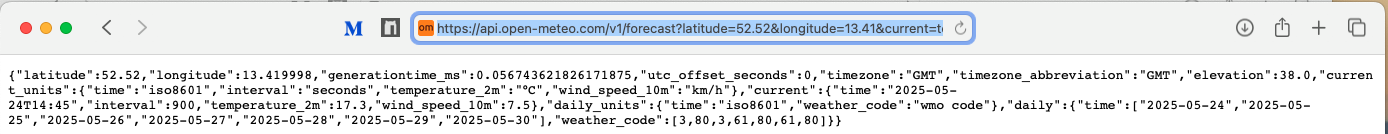


Le code ci-dessous montre comment obtenir le météo des jours à venir et comment nous l'archivons dans un DataFrame Pandas.

In [35]:
# Setup the Open-Meteo API client with cache and retry on error
# cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
# retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
# openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url_meteo = "https://api.open-meteo.com/v1/forecast"
params_meteo  = {
	"latitude": 52.52,
	"longitude": 13.41,
	"daily": "weather_code,apparent_temperature_max,apparent_temperature_min,precipitation_sum",
	"current": "weather_code",
	"timezone": "Europe/Berlin"
}
response=requests.get(url_meteo, params=params_meteo)
print(response.json()['daily'])

df_meteo=pd.DataFrame(response.json()['daily'])
df_meteo.info()
df_meteo

{'time': ['2025-10-28', '2025-10-29', '2025-10-30', '2025-10-31', '2025-11-01', '2025-11-02', '2025-11-03'], 'weather_code': [80, 3, 61, 3, 61, 80, 80], 'apparent_temperature_max': [8.3, 12.6, 9.2, 10.5, 13.6, 12.8, 8.2], 'apparent_temperature_min': [3.4, 4.8, 5.6, 3.2, 7.9, 8.3, 4.9], 'precipitation_sum': [3.6, 0.0, 4.5, 0.0, 0.3, 18.2, 2.8]}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      7 non-null      object 
 1   weather_code              7 non-null      int64  
 2   apparent_temperature_max  7 non-null      float64
 3   apparent_temperature_min  7 non-null      float64
 4   precipitation_sum         7 non-null      float64
dtypes: float64(3), int64(1), object(1)
memory usage: 412.0+ bytes


,time,weather_code,apparent_temperature_max,apparent_temperature_min,precipitation_sum
0,2025-10-28,80,8.3,3.4,3.6
1,2025-10-29,3,12.6,4.8,0.0
2,2025-10-30,61,9.2,5.6,4.5
3,2025-10-31,3,10.5,3.2,0.0
4,2025-11-01,61,13.6,7.9,0.3
5,2025-11-02,80,12.8,8.3,18.2
6,2025-11-03,80,8.2,4.9,2.8


# Discussion autour de l'appréciation. d'une bonne météo pour un séjour

## L'indice WMO

En allant sur [ce lien](https://www.umr-cnrm.fr/dbfastex/tablesOMM/020003.an), le lecteur trouvera la correspondance entre le code entier et la description de la météo.
[Dictionnaire Json de l'interprétation du code WMO](https://gist.github.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c#file-descriptions-json)

### Considération sur les UV

Maximum quotidien dans l'indice UV à partir de 0. uv_index_clear_sky_max suppose des conditions sans nuages.
[Veuillez suivre les directives officielles de l'OMM pour l'indice ultraviolet.](https://www.who.int/news-room/questions-and-answers/item/radiation-the-ultraviolet-(uv)-index)



## Fonctions métier


In [36]:
class FRANCE(Exception):
    pass

one_week_in_list=[]
def nice_weather(poi_weather)->float:
  """
  fonction pour definir la note d'attractivité de la poi en fonction des
  valeurs journalières sur les 7 prochains jour de la météo.
  Il est bon de mettre en place une stratégie pour laisser le choix sur
  la méthode de calcul de l'indice d'attractivité.
  """
  return poi_weather['weather_code'].mean()

# iteration sur la liste des pois
pois_dict={}
poi_nom,poi_latitude,poi_longitude, poi_France,poi_id,poi_weather,poi_nice  = [], [], [], [], [], [], []
for poi in pois:
  print(poi)
  poi_nom.append(poi)
  chaine=poi.strip()
  params={}
  params['format']='json'
  params['q']=chaine.replace(" ","+")+",fr" #'gorges+du+verdon'
  #params['country']='FR' # il est nécessaire de restreindre la localisation pour éviter des surprises au niveau mondial.
  response=requests.get("https://nominatim.openstreetmap.org/search",params=params, headers=headers) #?q=gorges+du+verdon&format=json
  data= response.json()
  poi_id.append(int(data[0]['osm_id']))
  try:
    latitude=float(data[0]['lat'])
    poi_latitude.append(latitude)
    longitude=float(data[0]['lon'])
    poi_longitude.append(longitude)
    france=((data[0]['display_name']).find("France") >0)
    poi_France.append(france)
    if not france:
      raise (FRANCE())
  except FRANCE:
    print("le Point d'interêt n'est pas en France !")
  except OSError as err:
    print("OS error:", err)
  except ValueError:
    print("Could not convert data to an integer.")
  except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
    raise
  params_meteo={}
  params_meteo['latitude']=latitude
  params_meteo['longitude']=longitude
  params_meteo['daily']="weather_code,apparent_temperature_max,apparent_temperature_min,precipitation_sum"
  params_meteo['current']="weather_code"
  params_meteo['timezone']="Europe/Berlin"
  url_meteo = "https://api.open-meteo.com/v1/forecast"
  weather=requests.get(url_meteo, params=params_meteo)
  my_weather=weather.json()['daily']
  my_weather['poi']=poi
  df_meteo=pd.DataFrame(my_weather)
  poi_weather.append(df_meteo)
  poi_nice.append(nice_weather(df_meteo))
  print("_________________________________")

pois_dict["nom"]        =poi_nom  
pois_dict["id"]         =poi_id
pois_dict["france"]     =poi_France
pois_dict["latitude"]   =poi_latitude
pois_dict["longitude"]  =poi_longitude
pois_dict["weather"]    =poi_weather
pois_dict["nice"]       =poi_nice

df_pois=pd.DataFrame.from_dict(pois_dict)


Mont Saint Michel
_________________________________
St Malo
_________________________________
Bayeux
_________________________________
Le Havre
_________________________________
Rouen
_________________________________
Paris
_________________________________
Amiens
_________________________________
Lille
_________________________________
Strasbourg
_________________________________
Château du Haut-Kœnigsbourg 
_________________________________
Colmar
_________________________________
Eguisheim
_________________________________
Besançon
_________________________________
Dijon
_________________________________
Annecy
_________________________________
Grenoble
_________________________________
Lyon
_________________________________
Gorges du Verdon
_________________________________
Bormes les Mimosas
_________________________________
Cassis
_________________________________
Marseille
_________________________________
Aix en Provence
_________________________________
Avignon
_______________

Nous stockons dans un DataFrame Pandas le résultat des sites touristiques de l'indice d'attractivite nice créé pour ce projet et se basant sur l'indice de référence WMO.

In [37]:
display(df_pois.describe())
display(df_pois.info())
df_pois.head()

,id,latitude,longitude,nice
count,3.500000e+01,35.000000,35.000000,35.000000
mean,2.499339e+08,45.840992,3.395921,48.404082
std,1.228273e+09,2.590094,2.954036,12.462934
min,7.439000e+03,42.525050,-2.026041,18.714286
25%,7.485900e+04,43.512178,1.380777,41.285714
50%,1.143470e+05,45.187560,4.360069,49.857143
75%,3.972545e+05,48.417012,5.637707,57.428571
max,7.193513e+09,50.636565,7.750713,67.857143


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nom        35 non-null     object 
 1   id         35 non-null     int64  
 2   france     35 non-null     bool   
 3   latitude   35 non-null     float64
 4   longitude  35 non-null     float64
 5   weather    35 non-null     object 
 6   nice       35 non-null     float64
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 1.8+ KB


None

,nom,id,france,latitude,longitude,weather,nice
0,Mont Saint Michel,211285890,True,48.635954,-1.511460,time weather_code apparent_temperat...,40.428571
1,St Malo,905534,True,48.649518,-2.026041,time weather_code apparent_temperat...,33.857143
2,Bayeux,145776,True,49.276462,-0.702474,time weather_code apparent_temperat...,47.571429
3,Le Havre,104492,True,49.493898,0.107973,time weather_code apparent_temperat...,67.857143
4,Rouen,75628,True,49.440459,1.093966,time weather_code apparent_temperat...,54.714286


In [38]:
display(df_pois["weather"][df_pois['nom']=="Paris"].head())
df_pois.to_csv('Data/kayak.csv')

5             time  weather_code  apparent_temperat...
Name: weather, dtype: object


### 🏨 Scraper Booking.com

Maintenant que nous savons comment obtenir les coordonnées GPS et la météo des points d'interêt, il nous faut collecter les hôtels dans les alentours des points d'interêt pour constituer notre base de données de nos lieux de séjour. Comme **Booking Holdings** ne propose pas de base de données agrégée, il sera **plus rapide de collecter les données directement depuis Booking.com**.

L'obtention d'information se fait par des requêtes get comme celle qui suit :
```
https://www.booking.com/searchresults.fr.html?ss=Paris%2C+France&efdco=1&label=gog235jc-1DCAEoggI46AdIM1gDaE2IAQGYAQ24AQfIAQ3YAQPoAQGIAgGoAgO4AsecvsEGwAIB0gIkZGQ0NjIzZTEtMTdjNS00ZGYzLTg5OTktOGExNmMwNGZiYzk32AIE4AIB&sid=c5ea7df93d489d500c6c6fef40b91b41&aid=397594&lang=fr&sb=1&src_elem=sb&src=index&dest_id=-1456928&dest_type=city&checkin=2025-05-22&checkout=2025-06-04&group_adults=3&no_rooms=1&group_children=2&age=1&age=10&nflt=%3Bhotelfacility%3D4%3B
```


Nous allons extraire pour chaque Hôtel :

* le **nom de l’hôtel**,
* l’**URL** de sa page sur Booking.com,
* ses **coordonnées GPS** (latitude et longitude),
* le **score** attribué par les utilisateurs du site,
* la **description textuelle** de l’hôtel.


L'aspiration des informations d'une partie du site BOOKING se fait au moyen de l'outil [Scrapy](https://www.scrapy.org) et de requêtes XPath sur les pages web du site pour focaliser sur les informations ciblées.

Dans le repertoire Scraping, le code de scrapping personnaliser avec les requêtes Xpath est reporté. Le squelette a été construit en utilisant la commande :
```bash
scrapy startproject kayak
```
dans le repertoire ```Scraping```.
Les spiders contenant les expressions de recherche XPath et d'extraction d'hôtel sont cosnignés dans l fichier ```booking.py``` dans le repertoire ```Scraping/kayak/kayak/spiders```. Ils seront exploité en lançant les scrapers via différents proxy et avec de judicieux paramètres décrits dans le fichier ```Scraping/kayak/kayak/settings.py``` pour éviter les blocages du site cible.
Tout étant configuré, il ne reste plus qu'à lancer le moteur depuis le repertoire ```Scraping/kayak``` avec la commande :

```bash 
scrapy crawl booking -O results/kayak.json
```
L'execution de l'application scrapy nous fournit, dans le repertoire ```Scraping/kayak/results```, la banque de données d'hôtel dans un fichier au format json. Il s'agit d'un liste où chaque élément est un hôtel décrit par un dictionnaire contenant les informations recherchées. Ainsi par exemple, un hôtel pour la ville de Saint Malo est décrit par :
```json 
{
    "ville": "St Malo", 
    "nom": "Hôtel Le Nautilus", 
    "url": "https://www.booking.com/hotel/fr/le-nautilus.fr.html?aid=304142&label=gen173nr-10CAQoggJCDnNlYXJjaF9zdCBtYWxvSA1YBGhNiAEBmAEzuAEOyAEM2AED6AEB-AEBiAIBqAIBuALci4TFBsACAdICJDQxYTg0MWUzLWYzOGQtNDhmOC1iNTljLWE4ZjIxZjBiODlkMNgCAeACAQ&ucfs=1&arphpl=1&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=24&hapos=24&sr_order=popularity&srpvid=03ce9dee13fc003e&srepoch=1755383262&from=searchresults", 
    "description": ["L’Hôtel Le Nautilus occupe un bâtiment rénové du XVIIe siècle situé dans la ville fortifiée de Saint-Malo. Cet hôtel dispose d’un bar, d’une bagagerie et d’un salon commun. "],
    "stars": "2 sur 5", 
    "coordinates": "48.650727056010815,-2.0249454730163734"
}
```


Ci-dessous un exemple simple de requête:

In [39]:
# entête pour simuler un navigateur réel.
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

headers = {'User-Agent': 'Mon Navigateur Ouaib'}

booking=requests.get("https://www.booking.com/searchresults.fr.html?ss=Paris%2C+France&efdco=1&label=gog235jc-1DCAEoggI46AdIM1gDaE2IAQGYAQ24AQfIAQ3YAQPoAQGIAgGoAgO4AsecvsEGwAIB0gIkZGQ0NjIzZTEtMTdjNS00ZGYzLTg5OTktOGExNmMwNGZiYzk32AIE4AIB&sid=c5ea7df93d489d500c6c6fef40b91b41&aid=397594&lang=fr&sb=1&src_elem=sb&src=index&dest_id=-1456928&dest_type=city&checkin=2025-05-22&checkout=2025-06-04&group_adults=3&no_rooms=1&group_children=2&age=1&age=10&nflt=%3Bhotelfacility%3D4%3B",
                     headers=headers)
print(booking.content)

b'<!DOCTYPE html>\n<!--\nYou know you could be getting paid to poke around in our code?\nWe\'re hiring designers and developers to work in Amsterdam:\nhttps://careers.booking.com/\n-->\n<!-- wdot-802 -->\n<script type="text/javascript" nonce="ihRCcwEwU9WphCQ" src="https://cdn.cookielaw.org/consent/3ea94870-d4b1-483a-b1d2-faf1d982bb31/OtAutoBlock.js"></script>\n<script type="text/javascript" nonce="ihRCcwEwU9WphCQ">\n(function () {\ndocument.addEventListener(\'click\', function(e) {\nif (e.target && e.target.classList.contains(\'ot-preference-center-footer\')) {\ne.preventDefault();\nOptanon && Optanon.ToggleInfoDisplay();\n}\n});\ndocument.addEventListener(\'cookie_banner_closed\', function(e) {\nif (window.PCM && window.B && window.B.et) {\nwindow.B.et.goal((window.PCM.Marketing || window.PCM.Analytical) ? \'cookie_consent_accepted_policy_banner\' : \'cookie_consent_declined_policy_banner\');\n}\n});\n})();\n</script>\n<script type="text/javascript" nonce="ihRCcwEwU9WphCQ">\nwindow.PC

In [40]:
df_hotel=pd.read_json("Data/kayak.json", orient='records')
display(df_hotel)

ValueError: Unexpected character found when decoding array value (2)

A ce stade, nous possédons dans le repertoire Data, un fichier contenant les corrdonnées et identifiant des lieux d'interêt et un autre contenant les hôtels dans leur environs. De plus nous savons comment obtenir la météo sur les 5 prochains jours pour chacun de ces sites et leur donner une note d'attractivité météorologique.


### ☁️ Créer votre *Data Lake* avec S3

 Nous stockons alors nos jeux de données construit **stockez dans S3** sous forme d'un **fichier CSV** pour les lieux d'intérêt __kayak.csv__ et d'un fichier json pour les hôtels __kayak.json__.
 Le datalake contient des informations de Booking dans un [fichier csv](./Data/kayak.csv)  et la liste des lieux d'interêt avec leur coordonnées GPS dans un [fichier json](./Data/kayak.json) 



In [ ]:
df_kayak=df_hotel.merge(df_pois)
df_kayak

,ville,nom,url,description,stars,coordinates,id,france,latitude,longitude,weather,nice


In [ ]:

s3 = boto3.client('s3')
with open("./Data/kayak.csv", "rb") as f:
    s3.upload_fileobj(f, "francis-pradel-jedha-projects", "kayak/kayak.csv")
with open("./Data/kayak.json", "rb") as f:
    s3.upload_fileobj(f, "francis-pradel-jedha-projects", "kayak/kayak.json")

---

### ⚙️ ETL (Extract – Transform – Load)

Après avoir envoyé nos données sur **S3**, nous facilitons le travail de la future équipe Data Analysis en leur permettant d’accéder à des données propres depuis un **Data Warehouse** sous Postgresql 

Pour cela :

1. Créez une **base de données SQL** avec **Neon DB**.
2. **Extrayez vos données depuis S3**.
3. **Importez-les dans votre base Neon DB** nouvellement créée.

# Construction du Dataware House
Maintenant que nous avons notre datalake archivé sous la forme de deux fichiers pour les hôtels et les villes, nous allons structurer les données dans un dataware house.
Postgresql est le moteur de base de données retenus et pour le cadre de l'exercice, nous allons utiliser [Neon](https://neon.com) un service en ligne fournissant gratuitement des base de données Postgresql en mode ServerLess. Il s'agit d'une alternative gratuite au service RDS ou Aurora d'AWS pour des base de données Postgresql.

Nous allons construire une base de données en s'appuyant sur le schéma Entité Relation ci-dessous permettant de structurer la données efficacement.



```mermaid
erDiagram
    poi ||--o{ meteo : possède
    hotel ||--o{ poi : relié
    poi {
        string id
        string nom
        float latitude
        float longitude
        bool  france
    }
    meteo {
        string id
        string id_poi
    }
    hotel {
        string id
        string id_poi
        string nom
        string url
        string stars
        text description
    }
  ```

In [ ]:
df_poi=df_pois[['id','nom','latitude','longitude','france']]

In [ ]:
%pip install psycopg2-binary

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from sqlalchemy import text
import psycopg2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
base_url=f"postgresql+psycopg2://{DBUSER}:{DBPASS}@{DBHOST}/{DBNAME}?sslmode=require&channel_binding=require"
engine = create_engine(base_url, echo=True, isolation_level="AUTOCOMMIT")
Session = sessionmaker(bind=engine)
session = Session()

In [ ]:
engine = create_engine(base_url, isolation_level="AUTOCOMMIT")
namespace="jedha"
namedb="kayak"
# Create database if not exists
dbname = f"{namespace}_{namedb}"
with engine.connect() as conn:
    cusor = conn.execute(text(f"SELECT 1 FROM pg_database WHERE datname = '{dbname}'"))
    if not cusor.fetchone():
        conn.execute(text(f"CREATE DATABASE {dbname}"))

In [ ]:
base_url=f"postgresql+psycopg2://{DBUSER}:{DBPASS}@{DBHOST}/{dbname}?sslmode=require&channel_binding=require"
engine_kayak = create_engine(base_url, echo=True, isolation_level="AUTOCOMMIT")
Session = sessionmaker(bind=engine_kayak)
session = Session()

In [ ]:
with engine_kayak.connect() as conn:
    try: 
        conn.execute('CREATE DATABASE poi')
        conn.execute(text('CREATE DATABASE hotel'))
        conn.execute(text('CREATE DATABASE meteo'))
    except Exception as db_exc:
        logging.exception("Exception creating database: " + str(db_exc))  

2025-10-28 02:23:47,435 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-10-28 02:23:47,436 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-10-28 02:23:47,475 INFO sqlalchemy.engine.Engine select current_schema()
2025-10-28 02:23:47,478 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-10-28 02:23:47,545 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-10-28 02:23:47,547 INFO sqlalchemy.engine.Engine [raw sql] {}


Création d'une database de météo.

In [ ]:
df_meteo=pd.DataFrame()
for weather in df_pois["weather"]:
    df_meteo=pd.concat([df_meteo,weather])
display(df_meteo.describe())
display(df_meteo.info())

,weather_code,apparent_temperature_max,apparent_temperature_min,precipitation_sum
count,245.000000,245.000000,245.000000,245.000000
mean,48.383673,15.269388,8.759184,3.530204
std,31.673406,4.065085,3.766206,5.992022
min,0.000000,2.400000,-1.100000,0.000000
25%,3.000000,12.200000,6.100000,0.000000
50%,61.000000,15.300000,8.700000,1.300000
75%,80.000000,18.700000,11.400000,4.300000
max,95.000000,23.200000,16.900000,42.500000


<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 0 to 6
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      245 non-null    object 
 1   weather_code              245 non-null    int64  
 2   apparent_temperature_max  245 non-null    float64
 3   apparent_temperature_min  245 non-null    float64
 4   precipitation_sum         245 non-null    float64
 5   poi                       245 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 13.4+ KB


None

In [ ]:
df_meteo

,time,weather_code,apparent_temperature_max,apparent_temperature_min,precipitation_sum,poi
0,2025-10-28,3,12.9,8.6,0.1,Mont Saint Michel
1,2025-10-29,53,11.6,8.0,1.8,Mont Saint Michel
2,2025-10-30,51,11.1,5.7,0.1,Mont Saint Michel
3,2025-10-31,51,14.3,8.4,0.4,Mont Saint Michel
4,2025-11-01,61,11.9,7.7,3.5,Mont Saint Michel
...,...,...,...,...,...,...
2,2025-10-30,51,15.6,10.7,0.2,La Rochelle
3,2025-10-31,51,14.9,11.0,0.2,La Rochelle
4,2025-11-01,61,15.3,11.8,2.0,La Rochelle
5,2025-11-02,80,12.5,8.2,9.7,La Rochelle


In [ ]:
df_hotel.to_sql('hotel', con=engine_kayak, if_exists='replace', index=False)
df_poi.to_sql('poi', con=engine_kayak, if_exists='replace', index=False)
df_meteo.to_sql('meteo', con=engine_kayak, if_exists='append', index=False)

2025-10-28 02:23:47,668 INFO sqlalchemy.engine.Engine BEGIN (implicit; DBAPI should not BEGIN due to autocommit mode)
2025-10-28 02:23:47,684 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-10-28 02:23:47,686 INFO sqlalchemy.engine.Engine [generated in 0.00154s] {'table_name': 'hotel', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-10-28 02:23:47,730 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog

245

Ci-dessous une copie d'écran de la base de données neon Db avec nos trois tables formant notre datalake.
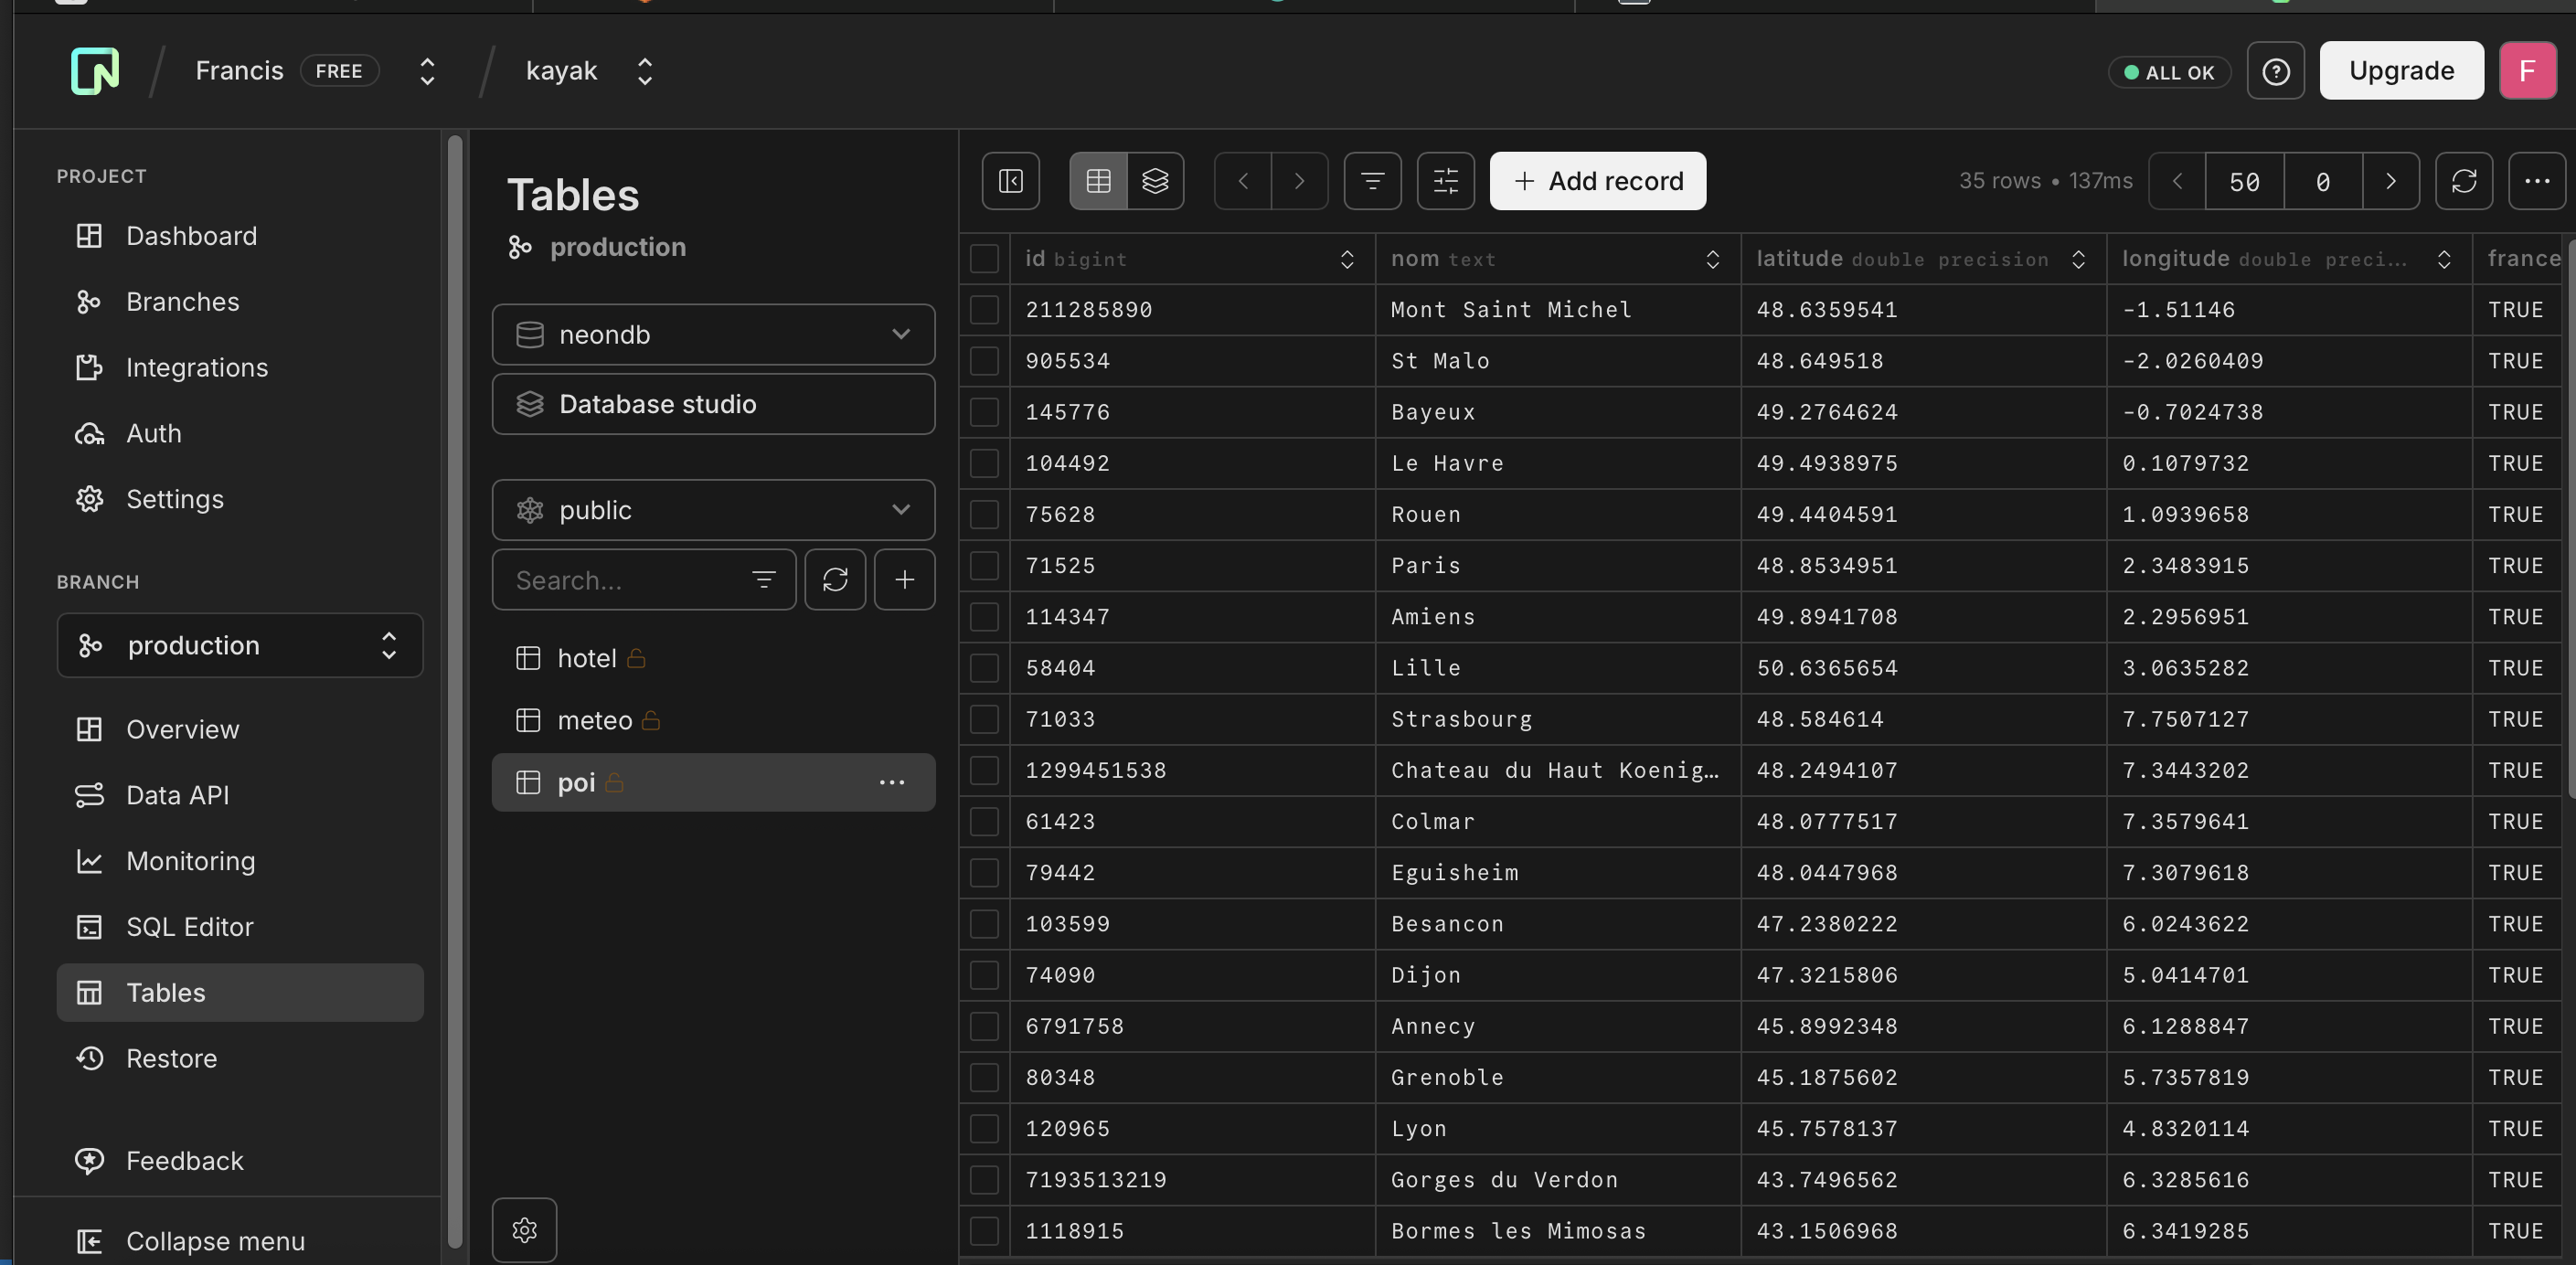

In [ ]:
df_read = pd.read_sql('hotel', con=engine_kayak)
print(df_read)

2025-10-28 02:23:49,718 INFO sqlalchemy.engine.Engine BEGIN (implicit; DBAPI should not BEGIN due to autocommit mode)
2025-10-28 02:23:49,721 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-10-28 02:23:49,722 INFO sqlalchemy.engine.Engine [cached since 2.038s ago] {'table_name': 'hotel', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-10-28 02:23:49,756 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catal

## Au final

Nous avons les sites touristiques :

In [ ]:
display(df_pois.describe()) 
display(df_pois.info()) 
display(df_pois.index) 


,id,latitude,longitude,nice
count,3.500000e+01,35.000000,35.000000,35.000000
mean,2.499339e+08,45.840992,3.395921,48.383673
std,1.228273e+09,2.590094,2.954036,12.366539
min,7.439000e+03,42.525050,-2.026041,18.714286
25%,7.485900e+04,43.512178,1.380777,42.000000
50%,1.143470e+05,45.187560,4.360069,49.142857
75%,3.972545e+05,48.417012,5.637707,58.428571
max,7.193513e+09,50.636565,7.750713,64.428571


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nom        35 non-null     object 
 1   id         35 non-null     int64  
 2   france     35 non-null     bool   
 3   latitude   35 non-null     float64
 4   longitude  35 non-null     float64
 5   weather    35 non-null     object 
 6   nice       35 non-null     float64
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 1.8+ KB


None

RangeIndex(start=0, stop=35, step=1)

Nous avons la météo pour chacun de ces 35 sites :

In [ ]:
df_pois['weather']


0              time  weather_code  apparent_temperat...
1              time  weather_code  apparent_temperat...
2              time  weather_code  apparent_temperat...
3              time  weather_code  apparent_temperat...
4              time  weather_code  apparent_temperat...
5              time  weather_code  apparent_temperat...
6              time  weather_code  apparent_temperat...
7              time  weather_code  apparent_temperat...
8              time  weather_code  apparent_temperat...
9              time  weather_code  apparent_temperat...
10             time  weather_code  apparent_temperat...
11             time  weather_code  apparent_temperat...
12             time  weather_code  apparent_temperat...
13             time  weather_code  apparent_temperat...
14             time  weather_code  apparent_temperat...
15             time  weather_code  apparent_temperat...
16             time  weather_code  apparent_temperat...
17             time  weather_code  apparent_temp

In [ ]:
def table_meteo(temps):
    for ele in temps.values:
        print (f"Weather Code {ele}")


def visu_poi(ele):
    print(f"Météo a venir pour : {ele.nom}")
    print("\t Date \t Code Météo")
    ele['weather'].apply(table_meteo)

df_pois.apply(visu_poi, axis=1)


Météo a venir pour : Mont Saint Michel
	 Date 	 Code Météo
Weather Code 2025-10-28
Weather Code 2025-10-29
Weather Code 2025-10-30
Weather Code 2025-10-31
Weather Code 2025-11-01
Weather Code 2025-11-02
Weather Code 2025-11-03
Weather Code 3
Weather Code 53
Weather Code 51
Weather Code 51
Weather Code 61
Weather Code 3
Weather Code 61
Weather Code 12.9
Weather Code 11.6
Weather Code 11.1
Weather Code 14.3
Weather Code 11.9
Weather Code 8.5
Weather Code 10.0
Weather Code 8.6
Weather Code 8.0
Weather Code 5.7
Weather Code 8.4
Weather Code 7.7
Weather Code 5.0
Weather Code 3.7
Weather Code 0.1
Weather Code 1.8
Weather Code 0.1
Weather Code 0.4
Weather Code 3.5
Weather Code 1.6
Weather Code 0.5
Weather Code Mont Saint Michel
Weather Code Mont Saint Michel
Weather Code Mont Saint Michel
Weather Code Mont Saint Michel
Weather Code Mont Saint Michel
Weather Code Mont Saint Michel
Weather Code Mont Saint Michel
Météo a venir pour : St Malo
	 Date 	 Code Météo
Weather Code 2025-10-28
Weather Co

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
dtype: object

## Viusalisation sur des cartes de la météo à venir.

Divers représentations de la météo sur les jours prochains pour ces 35 points d'intérêt.

In [ ]:

# pio.renderers.default = "svg" # this line must be commented if working on colab
import plotly.express as px
fig = px.scatter_map(df_pois, lat="latitude", lon="longitude", color="nice", size="nice",
                        hover_name='nom',
                        hover_data={
                            'nom': True,
                            'latitude': False,
                            'longitude': False,
                            'nice': True,
                            },
                        zoom=4, map_style="open-street-map", 
                        title="indice nice : Niveau de météo sur les 7 jours à venir sur les 35 jours.")
fig.show()

fig = px.scatter_map(
    df_pois[:35],
    lat='latitude',
    lon='longitude',
    color='nice',
    size='nice',
    color_continuous_scale=px.colors.sequential.Bluered,
    size_max=35,
    zoom=4.7,
    range_color = [min(df_pois[:35]['nice']), max(df_pois[:35]['nice'])],
    hover_name='nom',
    hover_data={
        'nom': True,
        'latitude': False,
        'longitude': False,
        'nice': True,
        },
    animation_frame='nom',
    labels={'nice': 'Nice indice'}
)

fig.update_layout(
    width = 1100,
    height = 800,
    title_x=0.5,
    title_text="Indice nice sur les 7 prochains jours pour chaque point d'intérêt.")
fig.show()

In [ ]:
df_top_5=df_pois.nlargest(5,['nice'])
df_top_5['nom']

8      Strasbourg
12       Besançon
14         Annecy
23           Uzes
34    La Rochelle
Name: nom, dtype: object

In [ ]:
for nom in df_top_5['nom']:
    print(nom)
    display(df_hotel[df_hotel["ville"]==nom])

Strasbourg


,ville,nom,url,description,stars,coordinates
308,Strasbourg,Novotel Strasbourg Centre Halles,https://www.booking.com/hotel/fr/novotel-stras...,[Le Novotel Strasbourg Centre Halles vous accu...,4 sur 5,None
309,Strasbourg,Hôtel le Grillon,https://www.booking.com/hotel/fr/grillonstrasb...,[Cet hôtel est situé dans le centre de Strasbo...,3 sur 5,None
313,Strasbourg,Citadines Eurometropole Strasbourg,https://www.booking.com/hotel/fr/citadines-eur...,"[Situé à Strasbourg (Alsace), l’établissement ...",4 sur 5,"48.60427412195041,7.7044611217040915"
386,Strasbourg,Hotel des Vosges BW Premier Collection,https://www.booking.com/hotel/fr/des-vosges.fr...,[None],4 sur 5,None
388,Strasbourg,LIFE RENAISSANCE - New Concept - Place Kléber,https://www.booking.com/hotel/fr/life-renaissa...,[Le LIFE RENAISSANCE - New Concept - Place Klé...,4 sur 5,None
389,Strasbourg,Hôtel Restaurant Athena Spa,https://www.booking.com/hotel/fr/athena-spa.fr...,[Installé à moins de 3 km du centre-ville de S...,4 sur 5,"48.59173665086212,7.711704969406128"
390,Strasbourg,Hôtel Garrigae Villa La Florangerie - SPA & Pi...,https://www.booking.com/hotel/fr/villa-novarin...,[None],4 sur 5,None
391,Strasbourg,Hôtel de l'Europe by HappyCulture,https://www.booking.com/hotel/fr/leurope.fr.ht...,[L’Hôtel de l'Europe by HappyCulture propose d...,4 sur 5,"48.5820969961667,7.742939963936806"
392,Strasbourg,Hotel & Spa REGENT PETITE FRANCE,https://www.booking.com/hotel/fr/regentpetitef...,[None],5 sur 5,None
393,Strasbourg,Appartements de la Pléiade,https://www.booking.com/hotel/fr/les-apparteme...,"[Doté d’une connexion Wi-Fi gratuite, l’établi...",4 sur 5,None


Besançon


,ville,nom,url,description,stars,coordinates


Annecy


,ville,nom,url,description,stars,coordinates
316,Annecy,Hébé Hotel,https://www.booking.com/hotel/fr/alery.fr.html...,[Hébé Hotel is located in the centre of Annecy...,4 sur 5,None
318,Annecy,ALPES Annecy Rent Lodge,https://www.booking.com/hotel/fr/alpes-by-anne...,[L’hébergement ALPES Annecy Rent Lodge se trou...,4 sur 5,"45.8990746,6.1281462"
343,Annecy,Novotel Annecy Centre,https://www.booking.com/hotel/fr/annecy-centre...,[None],4 sur 5,None
344,Annecy,Le Luxury Design de la Vieille Ville,https://www.booking.com/hotel/fr/le-luxury-des...,[L’établissement Le Luxury Design de la Vieill...,4 sur 5,"45.898321764953,6.12479564418"
345,Annecy,Apparthotel Privilodges Le Royal,https://www.booking.com/hotel/fr/le-royal.fr.h...,[Le Privilodges Le Royal - Apparthotel vous ac...,3 sur 5,None
346,Annecy,Hotel Les Terrasses,https://www.booking.com/hotel/fr/les-terrasses...,[L’Hotel Les Terrasses vous accueille dans le ...,3 sur 5,None
347,Annecy,Hôtel de Bonlieu,https://www.booking.com/hotel/fr/hoteldebonlie...,[Situé à 500 mètres du lac d'Annecy et à 12 mi...,3 sur 5,None
348,Annecy,Hôtel Catalpa,https://www.booking.com/hotel/fr/au-faisan-dor...,"[Situé juste à côté des rives du lac d'Annecy,...",3 sur 5,"45.905514493453836,6.144128143787384"
349,Annecy,Aparthotel Adagio Annecy Centre,https://www.booking.com/hotel/fr/adagio-city-a...,"[Doté dune salle de sport, l'Aparthotel Adagio...",4 sur 5,"45.903201977941485,6.122673153877258"
350,Annecy,Hôtel Les Muses,https://www.booking.com/hotel/fr/marina-bay-ho...,"[Situé à Annecy-le-Vieux, dans les Alpes franç...",3 sur 5,None


Uzes


,ville,nom,url,description,stars,coordinates
530,Uzes,Appartement dans Hotel de Flaux,https://www.booking.com/hotel/fr/appartement-d...,[L’hébergement Appartement dans Hotel de Flaux...,3 sur 5,None
533,Uzes,La Villa Léa,https://www.booking.com/hotel/fr/la-villa-lea....,[Situé à Uzès et offrant une vue sur le jardin...,4 sur 5,"44.01436230104396,4.410919646627008"
657,Uzes,Maison De La Bourgade,https://www.booking.com/hotel/fr/maison-de-la-...,[L’établissement Maison De La Bourgade se trou...,4 sur 5,None
659,Uzes,les bignones,https://www.booking.com/hotel/fr/les-bignones....,"[Offrant une vue sur le jardin, l’hébergement ...",4 sur 5,None
660,Uzes,Chez Louis de Uzès,https://www.booking.com/hotel/fr/chez-louis-de...,[L’hébergement Chez Louis de Uzès vous accueil...,4 sur 5,"44.012016397995,4.410644551949"
661,Uzes,Le trente trois,https://www.booking.com/hotel/fr/le-trente-tro...,"[Situé à Uzès, l’établissement Le trente trois...",3 sur 5,None
662,Uzes,Les cèdres,https://www.booking.com/hotel/fr/les-cedres-uz...,"[Situé à Uzès, à 39 km du palais des Papes, l'...",3 sur 5,"44.011847405338,4.414136186178"
663,Uzes,Grand studio sur jardin en centre-ville,https://www.booking.com/hotel/fr/appartement-s...,"[Situé à Uzès, l’hébergement Grand studio sur ...",3 sur 5,None
664,Uzes,Le Cherche Midi - Appartement centre historiqu...,https://www.booking.com/hotel/fr/appartement-c...,[L’hébergement Le Cherche Midi - Appartement c...,3 sur 5,None
665,Uzes,"""La Suite"" 3 Etoiles",https://www.booking.com/hotel/fr/la-suite-a-50...,"[L’hébergement ""La Suite"" 3 Etoiles se trouve ...",3 sur 5,"44.0114872,4.4198868000000004"


La Rochelle


,ville,nom,url,description,stars,coordinates
542,La Rochelle,Vue exceptionnelle sur les Tours ! Charme et t...,https://www.booking.com/hotel/fr/vue-exception...,[L’hébergement Vue exceptionnelle sur les Tour...,3 sur 5,None
543,La Rochelle,"Yacht La Rochelle, 5 pers, 2 sdb",https://www.booking.com/hotel/fr/yacht-la-roch...,"[L’hébergement Yacht La Rochelle, 5 pers, 2 sd...",None,"46.154394145219,-1.150396187033"
544,La Rochelle,Appartements Les Rochelais,https://www.booking.com/hotel/fr/appartements-...,[L’établissement Appartements Les Rochelais se...,3 sur 5,None
545,La Rochelle,"Maison M, chambre privée accès jardin piscine ...",https://www.booking.com/hotel/fr/maison-m-cham...,"[Proposant une piscine, un jardin, une terrass...",3 sur 5,"46.1876808,-1.1625471"
546,La Rochelle,le Gabut vue port,https://www.booking.com/hotel/fr/le-gabut-vue-...,[L’hébergement le Gabut vue port se trouve dan...,4 sur 5,"46.1555729,-1.149602"
547,La Rochelle,Central Park Hôtel & Spa,https://www.booking.com/hotel/fr/central-park-...,[Le Central Park Hôtel & Spa est un établissem...,4 sur 5,None
548,La Rochelle,Appartement Saint Claude - Centre Port,https://www.booking.com/hotel/fr/retour-de-pla...,[L’hébergement Appartement Saint Claude - Cent...,3 sur 5,"46.1574106,-1.1460796"
549,La Rochelle,Hôtel La Fabrique,https://www.booking.com/hotel/fr/la-fabrique-l...,[L’Hôtel La Fabrique se trouve à La Rochelle. ...,3 sur 5,None
550,La Rochelle,Novotel La Rochelle Centre,https://www.booking.com/hotel/fr/la-rochelle-c...,[None],4 sur 5,None
551,La Rochelle,Superbe T2 de 45m² en hyper centre,https://www.booking.com/hotel/fr/superbe-t2-de...,[L’hébergement Superbe T2 de 45m² en hyper cen...,3 sur 5,"46.158334,-1.155612"


Dans le repertoire App se trouve la synthèse en une web application sous Streamlit déployée sur AWS qui permet d'exposer simplement le résultat de ce projet.

La version web du projet est consultable à l'url : <https://dd0kljvyoc0fk.cloudfront.net>

